### SSIoT traffic analysis

In [2]:
import pandas as pd
import sys
from os import listdir
from os.path import isfile, join
import re
from matplotlib import pyplot as plt

In [3]:
path = "C:\\Users\\Raphael\\github\\Security-Services-for-IoT\\Final-Project\\pcap\\processed\\csv-files\\"
filenames = [f for f in listdir(path) if isfile(join(path, f))]
exclude= ["MiLampStartUp.csv", "MiLampStartUp2.csv"]

In [4]:
sametest = []
checked = set()
for file in filenames:
    if file in exclude:
        continue
    same = []
    file = file.split(".")[0]
    for name in filenames:
        if file in name and file != name:
            if name not in checked:
                #name = name.split(".")[0]
                same.append(name)
                checked.add(name)
    if len(same) > 0:
        sametest.append(same)

In [5]:
print(sametest[0][0])

MiLampAdjustBrightnessInApp.csv


In [6]:
df = pd.DataFrame()


In [7]:
for files in sametest:
    tm = pd.DataFrame()
    for i in range(len(files)):
        tm = pd.concat([tm, pd.read_csv(path + files[i], header=0)],ignore_index=False)
    tm["label"] = str(files[0].split(".")[0])
    df = pd.concat([df,tm], ignore_index=False)
df = df.reset_index(drop=True)

In [8]:
for i in range(df.shape[0]):
    date = str(df.at[i,"frame.time"]).split(" ")
    if len(date) == 7:
        df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[4])
    else:
        df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[3])


In [9]:
df.head()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,label
0,1,2020-06-14 17:27:27.884190,46:85:00:12:35:54,40:31:3c:d3:23:d4,3.124.122.199,192.168.137.47,17.0,21310070000000000721ae555edbb5de8052a323ad33df...,112.0,8053.0,54321.0,120.0,"XIAOMI Electronics,CO.,LTD",MiLampAdjustBrightnessInApp
1,2,2020-06-14 17:27:27.954667,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310040000000000721ae555edbb5df7efea2fd7132c2...,64.0,54321.0,8053.0,72.0,"XIAOMI Electronics,CO.,LTD",MiLampAdjustBrightnessInApp
2,3,2020-06-14 17:27:27.959515,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310060000000000721ae555edbb5df44b21b3ee0d9d9...,96.0,54321.0,8053.0,104.0,"XIAOMI Electronics,CO.,LTD",MiLampAdjustBrightnessInApp
3,4,2020-06-14 17:27:27.996886,46:85:00:12:35:54,40:31:3c:d3:23:d4,3.124.122.199,192.168.137.47,17.0,21310040000000000721ae555edbb5dfb22f2601dc3317...,64.0,8053.0,54321.0,72.0,"XIAOMI Electronics,CO.,LTD",MiLampAdjustBrightnessInApp
4,5,2020-06-14 17:27:28.805023,46:85:00:12:35:54,40:31:3c:d3:23:d4,3.124.122.199,192.168.137.47,17.0,21310070000000000721ae555edbb5df57f80dc3b3d676...,112.0,8053.0,54321.0,120.0,"XIAOMI Electronics,CO.,LTD",MiLampAdjustBrightnessInApp


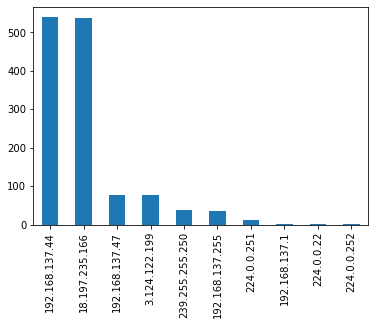

In [10]:
df["ip.dst"].value_counts().plot(kind="bar")

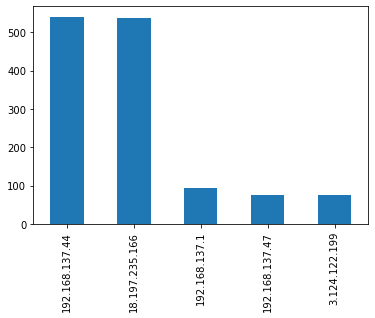

In [11]:
df["ip.src"].value_counts().plot(kind="bar")

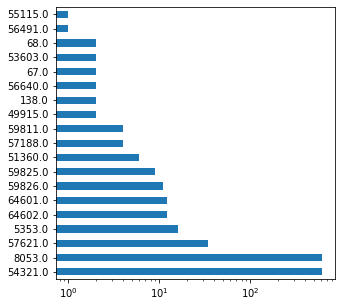

In [12]:
df["udp.srcport"].value_counts().plot(kind="barh", figsize=(5,5), logx=True)

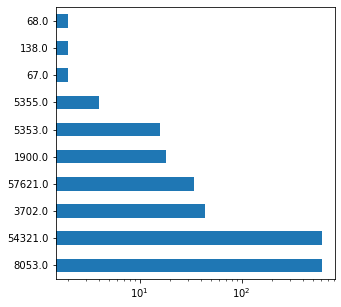

In [13]:
df["udp.dstport"].value_counts().plot(kind="barh", figsize=(5,5), logx=True)

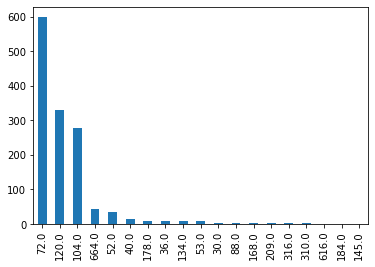

In [14]:
df["udp.length"].value_counts().plot(kind="bar")

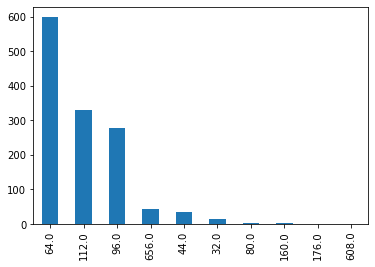

In [15]:
df["data.len"].value_counts().plot(kind="bar")

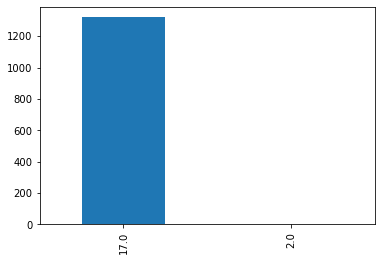

In [16]:
df["ip.proto"].value_counts().plot(kind="bar")